# Demo - White Box Attack with Imagenet

In [1]:
import numpy as np
import json
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    
# Using normalization for Inception v3.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],                     
#                          std=[0.229, 0.224, 0.225])
# However, do not use normalization transforms in this section.
# torchattacks only supports images with a range between 0 and 1.
# Thus, please refer to the model construction section.
    
])

## 1. Load Data

In [6]:
normal_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
normal_loader = torch.utils.data.DataLoader(normal_data, batch_size=1, shuffle=False)

True Image & True Label


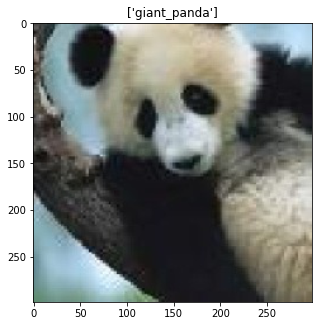

In [7]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 2. Attack Inception v3

In [8]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [9]:
# Adding normalization layer for Inception v3.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.inception_v3(pretrained=True)
).to(device)


In [10]:
model.eval()

FGSM = torchattacks.FGSM(model, eps=0.007)
BIM = torchattacks.BIM(model, eps=4/255, alpha=1/255, steps=0)
StepLL = torchattacks.StepLL(model, eps=4/255, alpha=1/255, steps=0)
RFGSM = torchattacks.RFGSM(model, eps=16/255, alpha=8/255, steps=5)
CW = torchattacks.CW(model, targeted=False, c=1, kappa=0, steps=1000, lr=0.01)
PGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40)
RPGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40, random_start=True)
DeepFool = torchattacks.DeepFool(model, steps=10)
FFGSM = torchattacks.FFGSM(model, eps=8/255, alpha=10/255)
TPGD = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=7)

attacks = [FGSM, BIM, StepLL, RFGSM, CW, PGD, RPGD,
           DeepFool, FFGSM, TPGD]

Attack Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.007)


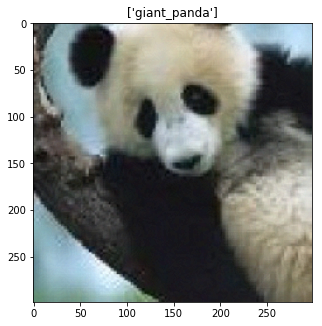

Test Accuracy: 100.000000 %
----------------------------------------------------------------------
BIM(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.01568627450980392, alpha=0.00392156862745098, steps=5)


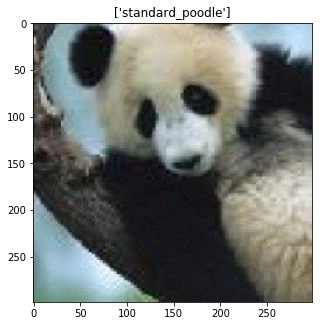

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
StepLL(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.01568627450980392, alpha=0.00392156862745098, steps=5)


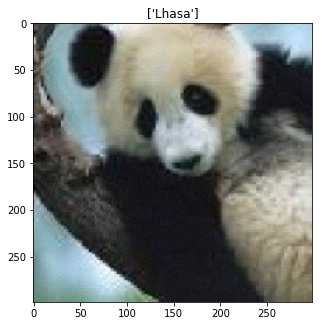

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
RFGSM(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.06274509803921569, alpha=0.03137254901960784, steps=5)


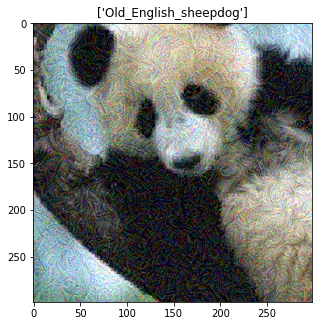

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
CW(model_name=Sequential, training=False, device=cuda:0, mode=float, targeted=False, c=1, kappa=0, steps=1000, lr=0.01)


C:\Users\slcf\workspace\GitHub\adversarial-attacks-pytorch\torchattacks\attacks\cw.py:100: UserWarning: Early Stopped cause the loss did not converged.
  warnings.warn("Early Stopped cause the loss did not converged.")


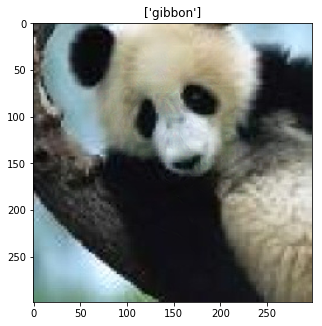

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
PGD(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.3, alpha=0.00784313725490196, steps=40, random_start=False, sign=1)


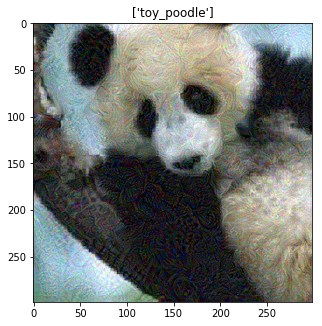

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
PGD(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.3, alpha=0.00784313725490196, steps=40, random_start=True, sign=1)


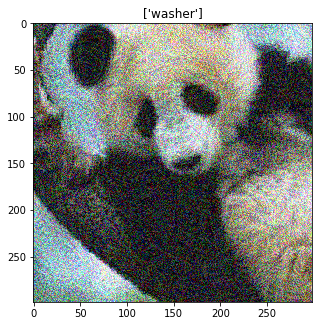

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
DeepFool(model_name=Sequential, training=False, device=cuda:0, mode=float, steps=10)


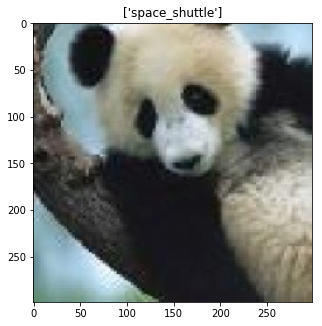

Test Accuracy: 0.000000 %
----------------------------------------------------------------------
FFGSM(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.03137254901960784, alpha=0.0392156862745098)


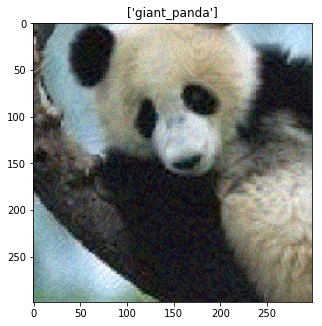

Test Accuracy: 100.000000 %
----------------------------------------------------------------------
TPGD(model_name=Sequential, training=False, device=cuda:0, mode=float, eps=0.03137254901960784, alpha=0.00784313725490196, steps=7)


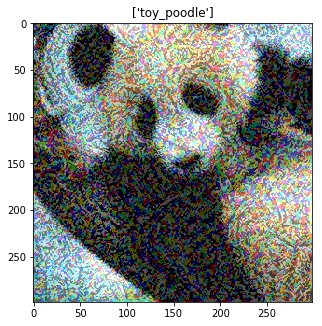

Test Accuracy: 0.000000 %


In [11]:
print("Attack Image & Predicted Label")

for attack in attacks :
    
    print("-"*70)
    print(attack)
    
    correct = 0
    total = 0
    
    for images, labels in normal_loader:

        images = attack(images, labels)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

    print('Test Accuracy: %f %%' % (100 * float(correct) / total))